In [302]:
import numpy as np
import pandas as pd
from functools import reduce
#all parameters
class conf:
    p_diabetes=0.447 #from OPTN 2013

    #the interval includes low, but excludes high
    age_range=[(18,35),(35,50),(50,65),(65,80)]
    p_age=[0.093,0.263,0.435,0.208]#from OPTN 2013

    dia_range=[(0,1),(1,2),(2,3),(3,4),(4,6),(6,11),(11,15)]
    p_dia=np.array([20.73,11.69,11.93,11.03,15.48,16.04,13.09])*0.01
    #from OPTN 2012, since 2013 only has graph, but no exact number
    
    p_piortr=15.4385*0.01 #2012 data
    #EPTS 2017 mapping threshold for top 20%
    ###problem: not accurate
    EPTS20=2.7073880890870 
    #CPRA
    CPRA_range=[(0,1),(1,20),(20,80),(80,98),(98,100)]
    p_CPRA=np.array([58.3,9.5,16.0,6.4,9.8])*0.01
    #waiting time
    waitime_range=[(0,1),(1,2),(2,3),(3,4),(4,5),(5,8)]
    p_waitime=np.array([28.6,21.5,16.0, 11.9, 7.9,14.1])*0.01

    patient_start=92582  #number of candidates on waitlitst at the start of 2013
    patient_end=96533 #number of candidates on waitlitst at the end of 2013
    patient_add=31532 #number of new patients
    patient_ddt=11277 #number of patients underwent deceased donor transplantation...thus 11277 kidneys available
    patient_ldt=5099 #number of patients underwent live donor transplantation
    patient_die=4722 #number of patients die before the surgery
    patient_remove=6483 #number of patients removed from the waiting list for other reason

    prior_donor=42 #number added to the waitlist
    p_prior_donor=prior_donor/patient_start
    #p mortaility
    p_mortality=patient_die/(patient_start+patient_add)
    p_livetr=patient_ldt/(patient_start+patient_add)
    p_remove=patient_remove/(patient_start+patient_add)
    p_censor=np.array([p_mortality,p_livetr,p_remove,1-p_mortality-p_livetr-p_remove])

    
    donors=7255 # imputed
    KDPI_range=[(0,0.21),(0.21,0.35),(0.35,0.86),(0.86,1.01)]
    p_KDPI=[0.22,0.16,0.53,0.09]
    p_DBD=0.85
    p_DBD_numkid=0.523333 #1.57 kidneys thus k=2 with p=0.523
    p_DCD_numkid=0.499999 #1.47 kidneys thus k=2 with p=



In [331]:
class patient_waitlist_char:
    def __init__(self, id):
        self._id = id
        ##the following is to calculate EPTS
        self._age_cat=np.random.multinomial(1, conf.p_age).tolist().index(1)
        #assume age is uniformly distributed within the each age category
        self._age=round(np.random.uniform(low=conf.age_range[self._age_cat][0],high=conf.age_range[self._age_cat][1]))

        self._diabetes=np.random.binomial(1,conf.p_diabetes)
        #from the plot, quite like uniform distribution range from 0 - 13
        self._diay_yearcat=np.random.multinomial(1, conf.p_dia).tolist().index(1)
        #assume dialysis year is uniformly distributed within the each age category
        self._diay_year=round(np.random.uniform(low=conf.dia_range[self._diay_yearcat][0],high=conf.dia_range[self._diay_yearcat][1]))
        self._Prior_tp=np.random.binomial(1,conf.p_piortr)
        self._EPTS=self.EPTS(self._age,self._diabetes,self._Prior_tp,self._diay_year)
                        
        self._death=np.random.binomial(1,conf.p_mortality)

        self._age_cat=np.random.multinomial(1, conf.p_age).tolist().index(1)

       
        #The following is for the total priority system
        #CPRA 
        self._cpracat=np.random.multinomial(1, conf.p_CPRA).tolist().index(1)
        self._cpra=round(np.random.uniform(low=conf.CPRA_range[self._cpracat][0],high=conf.CPRA_range[self._cpracat][1]))
        self._cprascore=self.CPRA_score()
        #waiting time 
        self._waitcat=np.random.multinomial(1, conf.p_waitime).tolist().index(1)
        self._waitime=round(np.random.uniform(low=conf.waitime_range[self._waitcat][0],high=conf.waitime_range[self._waitcat][1]))
        #Prior donor
        self._priordonor=np.random.binomial(1,conf.p_prior_donor)
        #calculate the point
        self._point=self.priority_point()
        #censoring, if the patient leave the cohort because of death, living donation or other reasons
        self._censor=(np.random.multinomial(1, conf.p_censor).tolist().index(1) != 3)
        self._priortyEPTS = (self._EPTS>= conf.EPTS20) & (self._censor==False)
            

    def get_info(self):
        df = pd.DataFrame([[self._id, self._age,self._age_cat, self._diabetes, self._priortyEPTS,self._EPTS, self._point,self._death,self._censor,self._waitime*52,self._cpra,self._diay_yearcat,self._Prior_tp,self._priordonor]])
        df.columns = ["id", "age","age_cat", "diabetes", "priorityEPTS","EPTS", "point","Death","Censor","waitime","cpra","Dialysis Year","Prior Transplant","Prior Donor"]
        df["time"] = -1
        return df

    def priority_point(self):
        return self._cprascore+self._waitime+self._priordonor*4

    def EPTS(self,age,diabetes,Prior_tp,diay_year):
        score=0.0473*max(age-25,0)-0.015*diabetes*max(age-25,0)+1.262*diabetes+0.398*Prior_tp-0.2373*diabetes*Prior_tp+0.315*np.log(diay_year+1)-0.099*diabetes*np.log(diay_year+1)+0.130*(diay_year==0)-0.348*diabetes*(diay_year==0)
        return score

    def CPRA_score(self):
        CPRA = self._cpra
        if CPRA<=19:
            return 0
        if CPRA<=29:
            return 0.08
        if CPRA<=39:
            return 0.21
        if CPRA<=49:
            return 0.34
        if CPRA <=59:
            return 0.48
        if CPRA <=69:
            return 0.81
        if CPRA<=74: 
            return 1.09
        if CPRA<=79:
            return 1.58
        if CPRA<=84:
            return 2.46
        if CPRA<=89:
            return 4.05
        if CPRA <=94:
            return 6.71
        if CPRA==95:
            return 10.82
        if CPRA==96:
            return 12.17
        if CPRA==97:
            return 17.3
        if CPRA==98:
            return 24.4
        if CPRA==99:
            return 50.09
        if CPRA==100:
            return 202.1


In [332]:
class Cohort:
    def __init__(self, popsize):
        """ create a cohort of patients
        :param id: an integer to specify the seed of the random number generator
        """
        self._initial_pop_size = popsize
        self._total_pop_size = popsize
        self._current_time = 0
        dfs = [patient_waitlist_char(i).get_info() for i in range(popsize)]
        self.df = pd.concat(dfs)
        self.df.index = self.df.id

    def get_countEPTSprior(self):
        return sum(self._patientsEPTS)

    def set_donors(self, donors):
        self.donors = donors

    def weekly_allocate_kidney(self):
        donor_df = self.donors.get_weekly_donor_info()
        num_provide_total = len(donor_df)
        num_provide_priority = len(donor_df[donor_df["kidneysLM"] == True])

        df_priorityEPTS_true = self.df[(self.df["priorityEPTS"] == True) & (self.df["time"] == -1) & (self.df["Censor"] == False)] 
        num_require_priority = len(df_priorityEPTS_true)
        if num_require_priority <= num_provide_priority:
            self.allocate_kidney_priorityEPTS(num_require_priority)
            self.allocate_kidney_nonpriorityEPTS(num_provide_total - num_require_priority)
        else:
            self.allocate_kidney_priorityEPTS(num_provide_priority)
            self.allocate_kidney_nonpriorityEPTS(num_provide_total - num_provide_priority)

    def allocate_kidney_priorityEPTS(self, num_kidney):
        df_priorityEPTS_true = self.df[(self.df["priorityEPTS"] == True) & (self.df["time"] == -1) & (self.df["Censor"] == False)] 
        
        selected_id = np.array(df_priorityEPTS_true.id)[np.random.choice(len(df_priorityEPTS_true), num_kidney, replace=False)]
        self.df.loc[selected_id, 'time'] = self._current_time

    def allocate_kidney_nonpriorityEPTS(self, num_kidney):
        df_priorityEPTS_false = self.df[(self.df["priorityEPTS"] == False) & (self.df["time"] == -1)  & (self.df["Censor"] == False)]

        selected_id = np.array(df_priorityEPTS_false.id)[np.argsort(df_priorityEPTS_false["point"])[::-1][:num_kidney]]
        self.df.loc[selected_id, 'time'] = self._current_time

    def add_new_patient(self, popsize):
        self._current_time += 1
        dfs = [patient_waitlist_char(i).get_info() for i in range(self._total_pop_size, self._total_pop_size+popsize)]
        self.df = pd.concat([self.df] + dfs)
        self.df.index = self.df.id
        self._total_pop_size += popsize


In [333]:
class Cohort_old:
    def __init__(self, popsize):
        """ create a cohort of patients
        :param id: an integer to specify the seed of the random number generator
        """
        self._initial_pop_size = popsize
        self._total_pop_size = popsize
        self._current_time = 0
        dfs = [patient_waitlist_char(i).get_info() for i in range(popsize)]
        self.df = pd.concat(dfs)
        self.df.index = self.df.id

   
    def set_donors(self, donors):
        self.donors = donors

    def weekly_allocate_kidney(self):
        donor_df = self.donors.get_weekly_donor_info()
        num_provide_total = len(donor_df)

        df_candidates = self.df[(self.df["time"] == -1) & (self.df["Censor"] == False)] 
        #df_candidates["waitime"]+=1
        selected_id = np.array(df_candidates.id)[np.argsort(df_candidates["waitime"])[::-1][:num_provide_total]]
        self.df.loc[selected_id, 'time'] = self._current_time

    def add_new_patient(self, popsize):
        self._current_time += 1
        dfs = [patient_waitlist_char(i).get_info() for i in range(self._total_pop_size, self._total_pop_size+popsize)]
        self.df = pd.concat([self.df] + dfs)
        self.df.index = self.df.id
        self._total_pop_size += popsize

In [334]:
class Donors:
    def __init__(self, donor_size):
        self._initial_donor_size = donor_size
        self._week = 0
        self._donor=[]
        self._kidney=[]
        np.random.seed(seed=123)

        dfs = [self.__init_get_donor_info() for _ in range(self._initial_donor_size)]
        self.df = pd.DataFrame(reduce(list.__add__, dfs))
        self.df = self.df.reset_index()
        self.df.columns = ["id", "kdpi"]
        self.df["kidneysLM"] = (self.df["kdpi"] <= 0.2)
        self._weekly_donor_size = len(self.df) // 52

    def __init_get_donor_info(self):
        kdpi=self.KDPI()
        self._DBD=np.random.binomial(1,conf.p_DBD)
        if self._DBD==1:
            self._numkidney=np.random.binomial(1,conf.p_DBD_numkid)+1
        else:
            self._numkidney=np.random.binomial(1,conf.p_DCD_numkid)+1
        if self._numkidney == 1:
            return [kdpi]
        else:
            return [kdpi, kdpi]

    def get_weekly_donor_info(self):
        week = self._week
        if week < 52:
            self._week += 1
            return self.df[(self._weekly_donor_size * week):(self._weekly_donor_size * week + self._weekly_donor_size)]
        
    def KDPI(self):
        KDPIcat=np.random.multinomial(1, conf.p_KDPI).tolist().index(1)
        KDPI=round(np.random.uniform(low=conf.KDPI_range[KDPIcat][0],high=conf.KDPI_range[KDPIcat][1]),2)
        return KDPI
    

In [335]:
d = Donors(conf.donors)
# d.df
# the initial cohort of 2013
c = Cohort(conf.patient_start)
c.set_donors(d)
#add new patients  606*32 weeks and 607*20 weeks
week_new=np.random.choice(52, 20, replace=False) 
for i in range(52):
    if i in week_new:
        c.add_new_patient(607)
    else:
        c.add_new_patient(606)
    c.weekly_allocate_kidney()



In [342]:
selected_id = c.df[c.df["time"]!=-1].id
c.df.loc[selected_id, "waitime_update"] = c.df.loc[selected_id, "waitime"] + c.df.loc[selected_id, "time"]

selected_id = c.df[c.df["time"]==-1].id
c.df.loc[selected_id, "waitime_update"] = None



# if c.df["time"]==-1:
#     c.df["waitime_update"]=c.df["waitime"]+52
c.df

,id,age,age_cat,diabetes,priorityEPTS,EPTS,point,Death,Censor,waitime,cpra,Dialysis Year,Prior Transplant,Prior Donor,time,waitime_update
id,,,,,,,,,,,,,,,,
0,0,71,1,0,False,2.682773,53.09,1,False,156,99,4,0,0,18,174.0
1,1,67,2,1,True,2.768320,1.00,0,False,52,0,1,0,0,-1,NaN
2,2,54,2,0,False,2.179659,0.00,0,False,0,1,6,0,0,-1,NaN
3,3,57,1,0,False,2.126562,2.48,0,False,104,50,4,0,0,-1,NaN
4,4,70,0,0,False,2.635473,12.82,0,False,104,95,3,0,0,-1,NaN
5,5,41,2,0,False,1.986103,6.05,0,False,104,87,6,1,0,-1,NaN
6,6,59,1,1,False,2.809359,1.00,0,True,52,1,5,0,0,-1,NaN
7,7,62,2,0,False,1.880100,208.10,0,False,312,100,0,0,0,2,314.0
8,8,71,2,1,True,3.196959,2.48,0,False,104,51,5,0,0,5,109.0


In [337]:
d2 = Donors(conf.donors)
# d.df
# the initial cohort of 2013
c2 = Cohort_old(conf.patient_start)
c2.set_donors(d2)
#add new patients  606*32 weeks and 607*20 weeks
week_new=np.random.choice(52, 20, replace=False) 
for i in range(52):
    if i in week_new:
        c2.add_new_patient(607)
    else:
        c2.add_new_patient(606)
    c2.weekly_allocate_kidney()
c2.df

,id,age,age_cat,diabetes,priorityEPTS,EPTS,point,Death,Censor,waitime,cpra,Dialysis Year,Prior Transplant,Prior Donor,time
id,,,,,,,,,,,,,,,
0,0,71,1,0,False,2.682773,53.09,1,False,156,99,4,0,0,-1
1,1,67,2,1,True,2.768320,1.00,0,False,52,0,1,0,0,-1
2,2,54,2,0,False,2.179659,0.00,0,False,0,1,6,0,0,-1
3,3,57,1,0,False,2.126562,2.48,0,False,104,50,4,0,0,-1
4,4,70,0,0,False,2.635473,12.82,0,False,104,95,3,0,0,-1
5,5,41,2,0,False,1.986103,6.05,0,False,104,87,6,1,0,-1
6,6,59,1,1,False,2.809359,1.00,0,True,52,1,5,0,0,-1
7,7,62,2,0,False,1.880100,208.10,0,False,312,100,0,0,0,-1
8,8,71,2,1,True,3.196959,2.48,0,False,104,51,5,0,0,-1


In [350]:
selected_id = c2.df[c2.df["time"]!=-1].id
c2.df.loc[selected_id, "waitime_update"] = c2.df.loc[selected_id, "waitime"] + c2.df.loc[selected_id, "time"]

selected_id = c2.df[c2.df["time"]==-1].id
c2.df.loc[selected_id, "waitime_update"] = None
c2.df[c2.df["time"]>-1]

,id,age,age_cat,diabetes,priorityEPTS,EPTS,point,Death,Censor,waitime,cpra,Dialysis Year,Prior Transplant,Prior Donor,time,waitime_update,Event,Kidney
id,,,,,,,,,,,,,,,,,,
46,46,38,0,0,False,1.121873,8.00,0,False,416,0,4,0,0,9,425.0,True,True
47,47,35,3,1,False,2.005317,13.71,0,False,364,91,4,0,0,33,397.0,True,True
49,49,60,0,0,False,2.438246,58.09,0,False,416,99,5,0,0,9,425.0,True,True
61,61,58,3,1,False,2.675539,57.09,0,False,364,99,3,0,0,33,397.0,True,True
73,73,51,2,0,False,1.985137,8.48,0,False,416,57,5,0,0,9,425.0,True,True
84,84,78,2,0,True,3.013873,8.34,0,False,416,45,3,0,0,9,425.0,True,True
100,100,77,2,1,True,2.884300,7.00,0,False,364,3,0,1,0,33,397.0,True,True
112,112,79,2,1,True,3.243500,25.30,0,False,416,97,1,0,0,9,425.0,True,True
132,132,33,0,1,False,1.907420,8.00,0,False,416,1,4,0,0,10,426.0,True,True


In [351]:
c.df.to_csv("c.csv")
c2.df.to_csv("c2.csv")

In [344]:
#define event and censor
c.df["Event"] = (c.df["Censor"] ==False)
c2.df["Event"] = (c2.df["Censor"] ==False)

#define whether get kidney
c.df["Kidney"] = (c.df["time"] >-1)
c2.df["Kidney"] = (c2.df["time"] >-1)

#c.df[(c.df.Censor == True) & (c.df.time != -1)]
c.df[c.df.Censor == True]

,id,age,age_cat,diabetes,priorityEPTS,EPTS,point,Death,Censor,waitime,cpra,Dialysis Year,Prior Transplant,Prior Donor,time,waitime_update,Event,Kidney
id,,,,,,,,,,,,,,,,,,
6,6,59,1,1,False,2.809359,1.00,0,True,52,1,5,0,0,-1,NaN,False,False
12,12,45,1,1,False,2.057720,4.00,0,True,208,0,0,0,0,-1,NaN,False,False
13,13,53,2,0,False,1.542741,3.00,0,True,156,0,0,0,0,-1,NaN,False,False
20,20,70,3,1,False,3.212858,2.00,0,True,104,0,5,0,0,-1,NaN,False,False
21,21,66,3,0,False,2.446273,0.00,0,True,0,6,3,0,0,-1,NaN,False,False
30,30,75,2,0,False,2.495000,5.00,0,True,260,0,0,0,0,-1,NaN,False,False
32,32,64,2,0,False,2.409104,2.00,0,True,104,0,4,0,0,-1,NaN,False,False
36,36,76,1,1,False,3.329617,1.00,0,True,52,1,4,0,0,-1,NaN,False,False
52,52,31,2,0,False,0.720483,3.00,0,True,156,0,3,0,0,-1,NaN,False,False


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


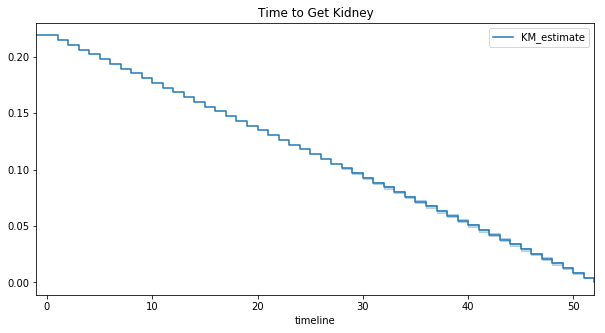

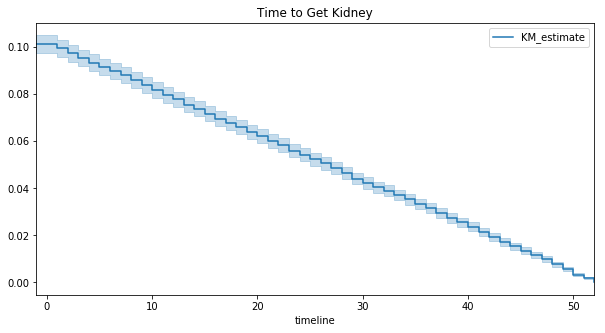

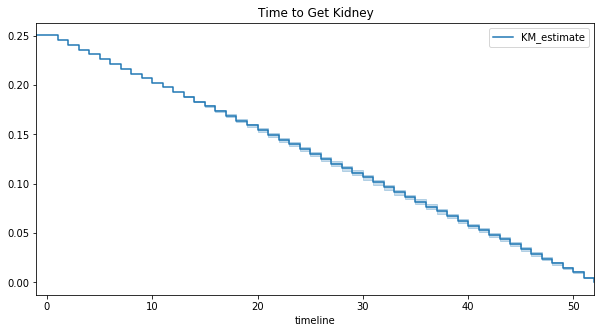

In [300]:
from lifelines.estimation import KaplanMeierFitter
import lifelines as ll

# Plotting helpers
from IPython.display import HTML
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls   
from plotly.graph_objs import *

from pylab import rcParams
rcParams['figure.figsize']=10, 5

kmf = KaplanMeierFitter()

control = c2.df[c2.df.priorityEPTS == True]
experiment =  c2.df[c2.df.priorityEPTS == False]

T_control = control['time']
C_control = control['Event']

T_exp = experiment['time']
C_exp = experiment['Event']

T = c2.df['time']
C = c2.df['Event']

kmf.fit(T, event_observed=C)
p = kmf.plot(title='Time to Get Kidney')
print(p)
kmf.fit(T_control, event_observed=C_control)
p = kmf.plot(title='Time to Get Kidney')
print(p)
kmf.fit(T_exp, event_observed=C_exp)
p = kmf.plot(title='Time to Get Kidney')
print(p)



t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p     
      226.0568 0.0000  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


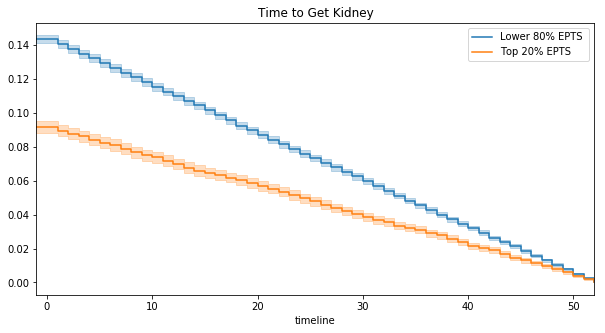

In [396]:
control = c.df[(c.df.priorityEPTS == True) & (c.df.Censor==False)]
experiment = c.df[(c.df.priorityEPTS == False)&(c2.df.Censor==False)]
T_control = control['time']
C_control = control['Event']

T_exp = experiment['time']
C_exp = experiment['Event']

ax = plt.subplot(111)

from lifelines import KaplanMeierFitter
kmf.fit(T_exp, event_observed=C_exp)
#p = kmf.plot(title='Time to Get Kidney')

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(T_exp, event_observed=C_exp, label='Lower 80% EPTS ').plot(ax=ax,title='Time to Get Kidney')

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(T_control, event_observed=C_control, label='Top 20% EPTS').plot(ax=ax)
plt.savefig("EPTS.png")

#log rank test
from lifelines.statistics import logrank_test
results = logrank_test(T_exp, T_control, event_observed_A=C_exp, event_observed_B=C_control)
results.print_summary()


C:\Users\lanxin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning:

reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead



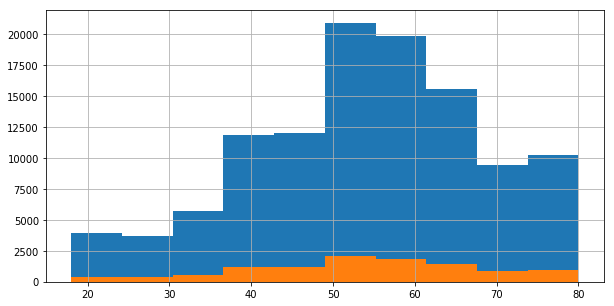

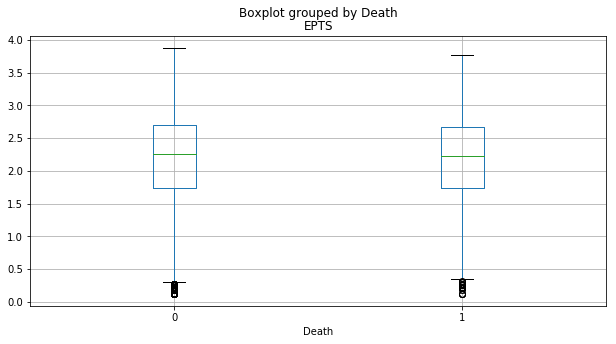

In [224]:
from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
grouped_data = c.df.groupby(['Kidney'])
#grouped_data['age'].describe().unstack()
label=("Transplanted","Kidney")
grouped_data['age'].hist(label=label)

c.df.boxplot(column='EPTS',by='Death')



In [172]:
c.df[(c.df.Censor == True) & (c.df.time != -1)]


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        3.5048 0.0612  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 



t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.0752 0.7839
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


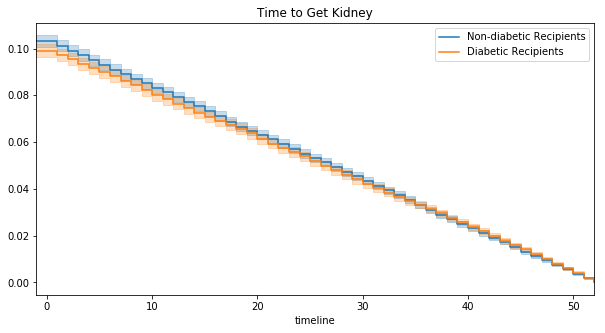

In [399]:
#compare diabetes
control = c.df[(c.df.diabetes == True)&(c.df.Censor==False)]
experiment = c.df[(c.df.diabetes == False)&(c.df.Censor==False)]
T_control = control['time']
C_control = control['Event']

T_exp = experiment['time']
C_exp = experiment['Event']

ax = plt.subplot(111)

from lifelines import KaplanMeierFitter
kmf.fit(T_exp, event_observed=C_exp)
#p = kmf.plot(title='Time to Get Kidney')

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(T_exp, event_observed=C_exp, label='Non-diabetic Recipients').plot(ax=ax,title='Time to Get Kidney')

kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(T_control, event_observed=C_control, label='Diabetic Recipients').plot(ax=ax)

plt.savefig("diabetes.png")

from lifelines.statistics import logrank_test
results = logrank_test(T_exp, T_control, event_observed_A=C_exp, event_observed_B=C_control)
results.print_summary()


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        0.0013 0.9716
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


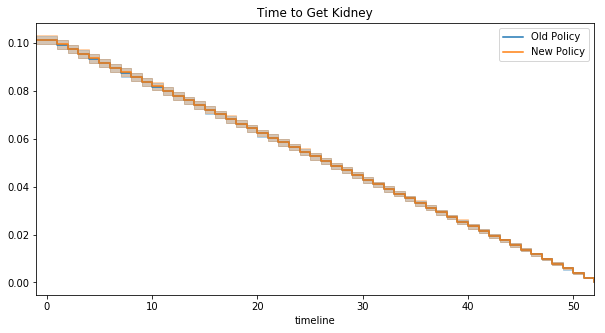

In [394]:
#compare two policy
control = c.df[c.df.Censor==False]
experiment = c2.df[c2.df.Censor==False]
T_control = control['time']
C_control = control['Event']

T_exp = experiment['time']
C_exp = experiment['Event']


ax = plt.subplot(111)

from lifelines import KaplanMeierFitter
kmf.fit(T_exp, event_observed=C_exp)
#p = kmf.plot(title='Time to Get Kidney')

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(T_exp, event_observed=C_exp, label='Old Policy').plot(ax=ax,title='Time to Get Kidney')


kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(T_control, event_observed=C_control, label='New Policy').plot(ax=ax)

plt.savefig("policycompare.png")


from lifelines.statistics import logrank_test
results = logrank_test(T_exp, T_control, event_observed_A=C_exp, event_observed_B=C_control)
results.print_summary()



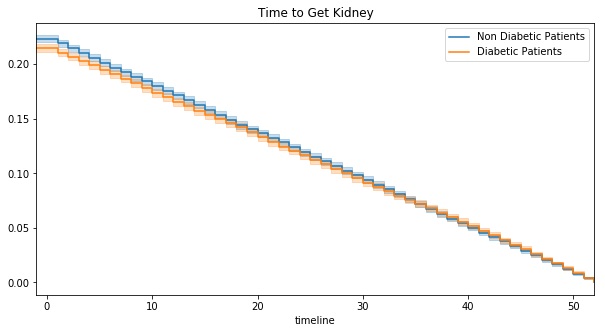


t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        3.5048 0.0612  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


In [370]:
#compare diabetic patients
control = c.df[c.df["diabetes"]==1]
experiment = c.df[c.df["diabetes"]==0]
T_control = control['time']
C_control = control['Event']

T_exp = experiment['time']
C_exp = experiment['Event']

ax = plt.subplot(111)

from lifelines import KaplanMeierFitter
kmf.fit(T_exp, event_observed=C_exp)
#p = kmf.plot(title='Time to Get Kidney')

kmf_exp = KaplanMeierFitter()
ax = kmf_exp.fit(T_exp, event_observed=C_exp, label='Non Diabetic Patients').plot(ax=ax,title='Time to Get Kidney')


kmf_control = KaplanMeierFitter()
ax = kmf_control.fit(T_control, event_observed=C_control, label='Diabetic Patients').plot(ax=ax)



from lifelines.statistics import logrank_test
results = logrank_test(T_exp, T_control, event_observed_A=C_exp, event_observed_B=C_control)
results.print_summary()



t_0=-1, alpha=0.95, null_distribution=chi squared, df=1

test_statistic      p   
        3.5048 0.0612  .
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 


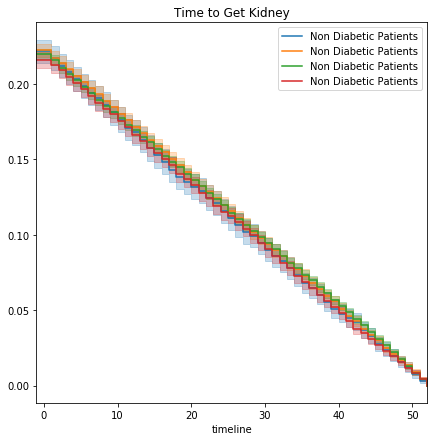

In [384]:
#compare diabetic patients
age0 = c.df[c.df["age_cat"]==0]
age1 = c.df[c.df["age_cat"]==1]
age2 = c.df[c.df["age_cat"]==2]
age3 = c.df[c.df["age_cat"]==3]
T0 = age0['time']
C0 = age0['Event']
T1 = age1['time']
C1 = age1['Event']
T2 = age2['time']
C2 = age2['Event']
T3 = age3['time']
C3 = age3['Event']

#plt.figure(figsize=(5, 4)) # This increases resolutionplt.show()
plt.figure(figsize=(7, 7))  # Don't create a humongous figure
#plt.annotate(fontsize=1)

ax = plt.subplot(111)

from lifelines import KaplanMeierFitter
ax = kmf.fit(T0, event_observed=C0, label='Non Diabetic Patients').plot(ax=ax,title='Time to Get Kidney')

ax = kmf.fit(T1, event_observed=C1, label='Non Diabetic Patients').plot(ax=ax,title='Time to Get Kidney')

ax = kmf.fit(T2, event_observed=C2, label='Non Diabetic Patients').plot(ax=ax,title='Time to Get Kidney')

ax = kmf.fit(T3, event_observed=C3, label='Non Diabetic Patients').plot(ax=ax,title='Time to Get Kidney')

plt.savefig("1.png")


from lifelines.statistics import logrank_test
results = logrank_test(T_exp, T_control, event_observed_A=C_exp, event_observed_B=C_control)
results.print_summary()








In [330]:
#t test for age
from scipy import stats 
import statsmodels.stats.api as sms
c_kidney=c.df[c.df.Kidney==True]
c_kidney2=c2.df[c2.df.Kidney==True]

print(stats.ttest_rel(c_kidney["age"],c_kidney2["age"]) )
cm = sms.CompareMeans(sms.DescrStatsW(c_kidney["age"],), sms.DescrStatsW(c_kidney2["age"]))
print(cm.tconfint_diff(usevar='unequal'))



Ttest_relResult(statistic=-1.137569004613181, pvalue=0.25532545668261275)
(-0.59675279381140456, 0.15774180480040906)


In [329]:
c_agecat = pd.crosstab(index=(c_kidney["age_cat"]), columns="count")
c2_agecat = pd.crosstab(index=(c_kidney2["age_cat"]), columns="count")
print(c_agecat)
print(c2_agecat)
stats.chisquare(f_obs= c_agecat,   # Array of observed counts
                f_exp= c2_agecat)   # Array of expected counts



col_0    count
age_cat       
0          968
1         2956
2         4790
3         2206
col_0    count
age_cat       
0         1008
1         2841
2         4739
3         2332


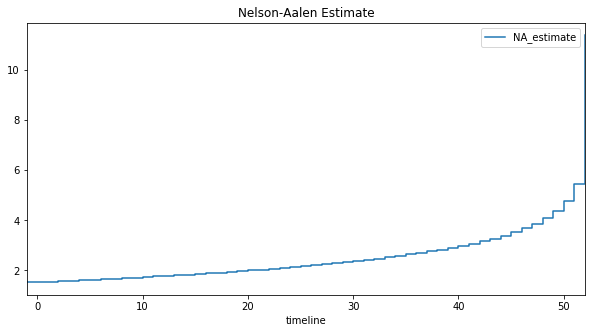

In [143]:
from lifelines.estimation import NelsonAalenFitter

naf = NelsonAalenFitter()
naf.fit(T, event_observed=C)

naf.plot(title='Nelson-Aalen Estimate')
